In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, count, sum

#Modeling
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('BigDataProject').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

## Data Cleanup

In [3]:
path = '/user/efischbein/data/group_project/'

In [4]:
sales = spark.read.csv(path + 'us_housing_prices/sales.csv', inferSchema=True, header=True)
Public_Schools = spark.read.csv(path + 'Public_Schools.csv', inferSchema=True, header=True)
State_time_series = spark.read.csv(path + 'zillow_econ/State_time_series.csv', inferSchema=True, header=True)
states = spark.read.csv(path + 'us_housing_prices/states.csv', inferSchema=True, header=True)

In [5]:
# Create temp view for spark.sql
sales.createOrReplaceTempView("sales")
Public_Schools.createOrReplaceTempView("Public_Schools")
State_time_series.createOrReplaceTempView("State_time_series")
states.createOrReplaceTempView("states")

### Clean sales.csv
Filters:
1. Drop null sales_price
2. Keep only properties with 1 unit (num_units = 1)

In [ ]:
# Filters applied:
sales = sales.drop("property_id","source_url","book","page","seller_name","buyer_name").distinct()\
                .filter(sales.sale_price. isNotNull())\
                .filter(sales.num_units == 1)

#### sales.csv Data Exploration

In [7]:
print(sales.count())
print(sales.distinct().count())

51328026
51327998


In [8]:
# Drop unnecessary columns
sales = sales.drop("property_id","source_url","book","page","seller_name","buyer_name").distinct()
print(sales.count())

51327990


In [12]:
# Check nulls
sales.select([count(when(col(c).isNull() , c)).alias(c) for c in sales.columns]).show()

+-----+--------+----------------+-------+-------+---------+-------------+----------+---------+----------+
|state|    zip5|physical_address|   city| county|sale_date|property_type|sale_price|num_units|year_built|
+-----+--------+----------------+-------+-------+---------+-------------+----------+---------+----------+
|    0|15466743|              48|9177731|2841775|       43|     22911065|        68| 35614847|  26927213|
+-----+--------+----------------+-------+-------+---------+-------------+----------+---------+----------+



In [13]:
# Drop rows where sale_price is null
sales = sales.filter(sales.sale_price. isNotNull())
sales.select([count(when(col(c).isNull() , c)).alias(c) for c in sales.columns]).show()

+-----+--------+----------------+-------+-------+---------+-------------+----------+---------+----------+
|state|    zip5|physical_address|   city| county|sale_date|property_type|sale_price|num_units|year_built|
+-----+--------+----------------+-------+-------+---------+-------------+----------+---------+----------+
|    0|15466702|               0|9177707|2841751|        0|     22911011|         0| 35614791|  26927145|
+-----+--------+----------------+-------+-------+---------+-------------+----------+---------+----------+



In [16]:
#state
sales.withColumn("state_length", F.length("state")).groupBy("state_length").count()

state_length,count
2,51327922


In [17]:
#zip5
sales.withColumn("zip5_length", F.length("zip5")).groupBy("zip5_length").count()

zip5_length,count
null,15466702
5,35861220


In [18]:
#num_units
sales.groupBy("num_units").count()

num_units,count
691,455
3606,565
296,15
WELLSFARGO FINANC...,1
1572,3
125,63
3517,5
MURIEL J.MCCARVILLE,1
3441,6
451,1


In [20]:
sales.filter(sales.num_units == 1).groupBy("num_units").count()

num_units,count
1,13796935


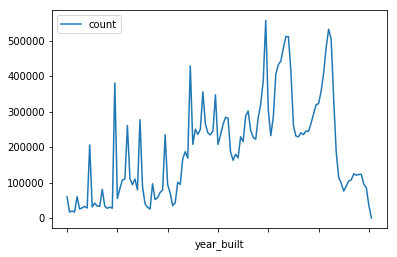

In [26]:
plot_year_built = sales.filter(F.col("year_built").cast("int").isNotNull())\
            .filter(sales.year_built > 1900)\
            .groupBy("year_built").count().toPandas().sort_values(by=['year_built'], ascending=True)
plot_year_built.plot.line(x='year_built', y='count')

### Clean Public_Schools
Filters/Transformations:
1. Group by State, Zip & sum Population and Enrollment Counts
2. One Hot Code: ST_GRADE & END_GRADE

In [54]:
# Filters applied:
Public_Schools = Public_Schools.select("STATE","ZIP","POPULATION","ENROLLMENT","ST_GRADE","END_GRADE")
## Population & Enrollment count
df1 = Public_Schools.groupBy("STATE","ZIP")\
    .agg(sum("POPULATION").alias("POPULATION"), sum("ENROLLMENT").alias("ENROLLMENT"))
print(df1.count())
df2 = Public_Schools.groupBy("STATE", "ZIP").pivot("ST_GRADE").agg(F.lit(1)).na.fill(0)
print(df2.count())

# Merge tables
Public_Schools_f = df1.join(df2, (df1["STATE"]== df2["STATE"]) & (df1["ZIP"]== df2["ZIP"]), "left")

In [55]:
print(df1.count())
print(df2.count())
print(Public_Schools_f.count())

22829
22829
22829


In [37]:
test = Public_Schools.groupBy("STATE","ZIP")\
    .agg(sum("POPULATION").alias("POPULATION"), sum("ENROLLMENT").alias("ENROLLMENT"))
test

STATE,ZIP,POPULATION,ENROLLMENT
AZ,85225,14723,17092
WI,53050,1268,1268
FL,34211,3558,3382
NE,69001,1535,1436
NY,14150,4550,4215
CA,94913,199,176
CA,94941,4780,4561
SD,57353,276,253
FL,32110,1391,1300
PA,16239,197,177


In [31]:
Public_Schools.printSchema()

root
 |-- STATE: string (nullable = true)
 |-- ZIP: string (nullable = true)
 |-- POPULATION: integer (nullable = true)
 |-- ENROLLMENT: integer (nullable = true)
 |-- ST_GRADE: string (nullable = true)
 |-- END_GRADE: string (nullable = true)



In [32]:
Public_Schools

STATE,ZIP,POPULATION,ENROLLMENT,ST_GRADE,END_GRADE
FL,32168,235,222,KG,05
LA,71485,333,312,PK,08
ME,04011,791,739,02,05
MS,39051,1222,1159,PK,05
MO,64060,296,274,KG,05
NE,68516,880,827,06,08
NV,89121,141,120,PK,13
NV,89141,1810,1739,06,08
NJ,08401,100,90,PK,PK
NJ,07090,2009,1854,09,12


In [33]:
Public_Schools.select([count(when(col(c).isNull() , c)).alias(c) for c in Public_Schools.columns]).show()

+-----+---+----------+----------+--------+---------+
|STATE|ZIP|POPULATION|ENROLLMENT|ST_GRADE|END_GRADE|
+-----+---+----------+----------+--------+---------+
|    0|  0|         0|         0|       0|        0|
+-----+---+----------+----------+--------+---------+



In [47]:
# ST_GRADE.withColumns([F.col(c).alias("ST_GRADE_"+c) for c in ST_GRADE.drop("STATE","ZIP").columns])

In [34]:
ST_GRADE = Public_Schools.groupBy("STATE", "ZIP").pivot("ST_GRADE").agg(F.lit(1)).na.fill(0)
ST_GRADE

STATE,ZIP,01,02,03,04,05,06,07,08,09,10,11,12,13,438,AE,KG,N,PK,UG
FL,32110,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0
KY,42303,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,1,1,0
AZ,85225,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,1,0
AZ,85226,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
SD,57625,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0
IL,62685,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
WI,53050,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
TX,75234,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0
TX,75132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
ND,58771,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Cleanup State_time_series

In [19]:
State_time_series2 = State_time_series.select\
            ("ZHVI_1bedroom",
            "ZHVI_CondoCoop",
            "ZHVI_2bedroom",
            "ZHVI_5BedroomOrMore",
            "ZHVI_BottomTier",
            "ZHVI_4bedroom",
            "ZHVI_AllHomes",
            "ZHVI_MiddleTier",
            "ZHVI_SingleFamilyResidence",
            "ZHVI_TopTier",
            "ZHVIPerSqft_AllHomes",
            "ZHVI_3bedroom",
            "RegionName",
            "Date").distinct().na.drop()

In [ ]:
print(State_time_series.count())
print(State_time_series2.count())

In [20]:
State_time_series2.createOrReplaceTempView("State_time_series2")

In [24]:
q = """
select * from 
(select *, 
row_number() over (partition by RegionName, year order by Date asc) as rank  
from 
(select *, substring(Date,1,4) as year  
from State_time_series2) x ) y 
where rank = 1
"""
State_time_series3 = spark.sql(q)

In [25]:
State_time_series3.count()

792

In [26]:
State_time_series3

ZHVI_1bedroom,ZHVI_CondoCoop,ZHVI_2bedroom,ZHVI_5BedroomOrMore,ZHVI_BottomTier,ZHVI_4bedroom,ZHVI_AllHomes,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZHVIPerSqft_AllHomes,ZHVI_3bedroom,RegionName,Date,year,rank
140600,168000,174800,394800,140000,328200,235900,235900,247000,420900,147,232100,Colorado,2014-01-31 00:00:00,2014,1
124900,172300,131800,247300,114700,208000,169100,169100,169100,289100,107,162800,Idaho,2016-01-31 00:00:00,2016,1
96200,123300,91500,319100,77700,249400,142100,142100,143600,278200,91,139800,NorthCarolina,2015-01-31 00:00:00,2015,1
206100,243200,228100,432900,168200,360900,273500,273500,277400,469700,170,271800,Washington,2009-01-31 00:00:00,2009,1
105500,148100,119800,250500,100600,213300,161300,161300,162800,270900,109,161000,Wisconsin,2017-01-31 00:00:00,2017,1
93400,140800,70500,337200,61300,236400,120600,120600,120100,237100,74,123300,Alabama,2016-01-31 00:00:00,2016,1
148600,186600,189400,443600,189600,346700,265300,265300,276200,377700,184,270100,Alaska,2009-01-31 00:00:00,2009,1
78000,114400,81900,256000,70700,200900,121300,121300,122200,217900,77,120000,NorthCarolina,2002-01-31 00:00:00,2002,1
160400,159500,178200,350600,139000,302700,223000,223000,227100,372000,145,218900,Oregon,2014-01-31 00:00:00,2014,1
77700,118200,95300,229000,67400,196300,116400,116400,115900,204700,84,121900,Kentucky,2007-01-31 00:00:00,2007,1


In [28]:
State_time_series3.createOrReplaceTempView("State_time_series3")

In [30]:
q = """
select a.*, b.code 
from State_time_series3 a 
left join states b 
on replace(a.RegionName, ' ', '') = replace(b.name, ' ', '') 
"""
State_time_series4 = spark.sql(q)
State_time_series4

ZHVI_1bedroom,ZHVI_CondoCoop,ZHVI_2bedroom,ZHVI_5BedroomOrMore,ZHVI_BottomTier,ZHVI_4bedroom,ZHVI_AllHomes,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZHVIPerSqft_AllHomes,ZHVI_3bedroom,RegionName,Date,year,rank,code
140600,168000,174800,394800,140000,328200,235900,235900,247000,420900,147,232100,Colorado,2014-01-31 00:00:00,2014,1,CO
124900,172300,131800,247300,114700,208000,169100,169100,169100,289100,107,162800,Idaho,2016-01-31 00:00:00,2016,1,ID
96200,123300,91500,319100,77700,249400,142100,142100,143600,278200,91,139800,NorthCarolina,2015-01-31 00:00:00,2015,1,NC
206100,243200,228100,432900,168200,360900,273500,273500,277400,469700,170,271800,Washington,2009-01-31 00:00:00,2009,1,WA
105500,148100,119800,250500,100600,213300,161300,161300,162800,270900,109,161000,Wisconsin,2017-01-31 00:00:00,2017,1,WI
93400,140800,70500,337200,61300,236400,120600,120600,120100,237100,74,123300,Alabama,2016-01-31 00:00:00,2016,1,AL
148600,186600,189400,443600,189600,346700,265300,265300,276200,377700,184,270100,Alaska,2009-01-31 00:00:00,2009,1,AK
78000,114400,81900,256000,70700,200900,121300,121300,122200,217900,77,120000,NorthCarolina,2002-01-31 00:00:00,2002,1,NC
160400,159500,178200,350600,139000,302700,223000,223000,227100,372000,145,218900,Oregon,2014-01-31 00:00:00,2014,1,OR
77700,118200,95300,229000,67400,196300,116400,116400,115900,204700,84,121900,Kentucky,2007-01-31 00:00:00,2007,1,KY


In [31]:
State_time_series4.count()

792

## Merge all tables together

## Modeling

In [56]:
## Import Data

### Feature Exploration

In [ ]:
# look at describe() function. Drop variables with low variablility.

# stats = clean.describe().T
# stats["std"] = stats["std"].round(2)
# stats["99%"] = clean.quantile(.99)
# stats = stats.sort_values(by=['std'])
# stats

## where std dev is close to 0, and 99 percentile = minimum (this means the highest value and lowest value are the same)

### Feature Correlation

In [57]:
## check variables that correlate well with the target variable
# remove variables that have high correlation with each other, or keep only 1

### Train/Test Split

In [ ]:
predictors = []

In [ ]:
#create input vector for modeling in pyspark
vectorAssembler = VectorAssembler(inputCols = predictors, outputCol = 'features')
vinput_data = vectorAssembler.transform(input_data)
vinput_data = vinput_data.select(['features', 'sales_price'])
vinput_data.show(1)

In [ ]:
# Train/Test Split
train_df, test_df = vinput_data.randomSplit([.7,.3],seed=1234)
train_df.show(10, truncate = True)

In [58]:
# Linear Regression
# Decision Tree
# Random Forest
# SVM maybe?
# Gradient Boosting
# KNNeighbors

### Linear Regression

In [ ]:
lr = LinearRegression(featuresCol = 'features', labelCol='MV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
print("p-Values: %f" % trainingSummary.pValues)

In [ ]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","MV","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="MV",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

### Random Forest

In [ ]:
#https://www.silect.is/blog/random-forest-models-in-spark-ml/

In [ ]:
rf = RandomForestRegressor(labelCol="label", featuresCol="features")

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

### Gradient Boosting

In [ ]:
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'MV', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'MV', 'features').show(5)

In [ ]:
gbt_evaluator = RegressionEvaluator(
    labelCol="MV", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

### KNearestNeighbor

### Final Model Summary

In [64]:
#models
#lr_model

print("Rsquared")
d = {"Model" : ["Linear Regression"], "Train" : [1], "Test" : [2]}
pd.DataFrame(d)

Rsquared


,Model,Train,Test
0,Linear Regression,1,2
